In [56]:
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np
import os
from os import listdir
from os.path import isfile, join

import glob

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [47]:
dataset_name = 'screws'
dataset_location = 'archive'
train_dataset = 'train'
test_dataset = 'test'
valid_dataset = 'valid'
train_dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location, train_dataset)
test_dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location, test_dataset)
valid_dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location, valid_dataset)

In [48]:
# classes
train_folders = [ f.path for f in os.scandir(train_dataset_path) if f.is_dir() ]
class_one = os.path.basename(train_folders[0])
class_two = os.path.basename(train_folders[1])
print(class_one)
print(class_two)

good
not-good


In [49]:
# classes
test_folders = [ f.path for f in os.scandir(test_dataset_path) if f.is_dir() ]
class_one = os.path.basename(test_folders[0])
class_two = os.path.basename(test_folders[1])
print(class_one)
print(class_two)

good
not-good


In [50]:
valid_folders = [ f.path for f in os.scandir(valid_dataset_path) if f.is_dir() ]
class_one = os.path.basename(valid_folders[0])
class_two = os.path.basename(valid_folders[1])
print(class_one)
print(class_two)

good
not-good


In [51]:
img_ext = ['png']

train_good_images = []
for i in range(len(img_ext)):
    train_good_images.extend([_ for _ in os.listdir(train_folders[0]) if _.endswith(img_ext[i])])
nb_train_good = len(train_good_images) 

train_notgood_images = []
for i in range(len(img_ext)):
    train_notgood_images.extend([_ for _ in os.listdir(train_folders[1]) if _.endswith(img_ext[i])])
nb_train_notgood = len(train_notgood_images) 

print(nb_train_good)
print(nb_train_notgood)

200
320


In [52]:
test_good_images = []
for i in range(len(img_ext)):
    test_good_images.extend([_ for _ in os.listdir(test_folders[0]) if _.endswith(img_ext[i])])
nb_test_good = len(test_good_images) 

test_notgood_images = []
for i in range(len(img_ext)):
    test_notgood_images.extend([_ for _ in os.listdir(test_folders[1]) if _.endswith(img_ext[i])])
nb_test_notgood = len(test_notgood_images) 

print(nb_test_good)
print(nb_test_notgood)

113
67


In [53]:
valid_good_images = []
for i in range(len(img_ext)):
    valid_good_images.extend([_ for _ in os.listdir(valid_folders[0]) if _.endswith(img_ext[i])])
nb_valid_good = len(valid_good_images) 

valid_notgood_images = []
for i in range(len(img_ext)):
    valid_notgood_images.extend([_ for _ in os.listdir(valid_folders[1]) if _.endswith(img_ext[i])])
nb_valid_notgood = len(valid_notgood_images) 

print(nb_valid_good)
print(nb_valid_notgood)

50
84


In [58]:
# load data function
IMG_DIM = (240, 240)

dataset_path = os.path.join(os.getcwd(), dataset_name, dataset_location)

def apply_permutation(data, indexes):
    n = len(data)
    result = np.empty(n, dtype=object)
    for i in range(n):
        result[i] = data[indexes[i]]
    return result

def load_dataset(data_type):
    path = join(dataset_path, data_type)
    files = []
    labels = []
    f_dir = [f for f in listdir(path) if not isfile(join(path, f))]

    for directory in f_dir:
        new_files = [join(path, directory, f) for f in listdir(join(path, directory)) if f.endswith('png')]
        files.extend(new_files)
        for f in new_files:
            labels.append(directory)

    # shuffling data
    shuffled_indices = np.random.permutation(len(files))
    files = apply_permutation(files, shuffled_indices)
    labels = apply_permutation(labels, shuffled_indices)
    imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in files]
    imgs = np.array(imgs)

    return imgs, labels

In [59]:
train_imgs, train_labels = load_dataset('train')
valid_imgs, valid_labels = load_dataset('valid')
test_imgs, test_labels = load_dataset('test')

print('Training dataset shape:', train_imgs.shape)
print('Validation dataset shape:', valid_imgs.shape)

Training dataset shape: (520, 240, 240, 3)
Validation dataset shape: (134, 240, 240, 3)


(240, 240, 3)


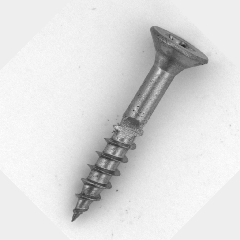

In [60]:
train_imgs_scaled = train_imgs.astype('float32')
train_imgs_scaled /= 255
valid_imgs_scaled = valid_imgs.astype('float32')
valid_imgs_scaled /= 255
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255


print(train_imgs[0].shape)
array_to_img(train_imgs_scaled[0])

In [61]:
batch_size = 32
num_classes = 2
epochs = 10
input_shape = (240, 240, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
le = LabelEncoder()
le.fit(valid_labels)
valid_labels_enc = le.transform(valid_labels)

print(train_labels[2:10], train_labels_enc[2:10])
print(valid_labels[2:10], valid_labels_enc[2:10])

# le.fit(valid_labels)
test_labels_enc = le.transform(test_labels)
print(test_labels[2:10], test_labels_enc[2:10])

['good' 'not-good' 'not-good' 'not-good' 'not-good' 'not-good' 'good'
 'good'] [0 1 1 1 1 1 0 0]
['not-good' 'good' 'not-good' 'good' 'good' 'good' 'good' 'good'] [1 0 1 0 0 0 0 0]
['not-good' 'not-good' 'good' 'good' 'good' 'not-good' 'good' 'good'] [1 1 0 0 0 1 0 0]


In [64]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

C:\Users\fatim\Anaconda3\envs\deeplearningdev\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001C9A9796AC8>,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0x000001C9A9796B70>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001C9A99114A8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001C9A9911C88>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001C9A9911D30>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001C9A99092E8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001C9A99244E0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001C9A9924780>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001C9A9934358>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001C9A9946B70>,block3_conv3,False


In [67]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("screw_classifier_model.h5", save_best_only=True, verbose=1) 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(valid_imgs_scaled, valid_labels_enc),
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=[checkpoint_cb, early_stopping_cb], verbose=1) 

Train on 520 samples, validate on 134 samples
Epoch 1/10
520/520 [==============================] - 164s 315ms/step - loss: 20.1592 - accuracy: 0.6135 - val_loss: 1.3633 - val_accuracy: 0.4851

Epoch 00001: val_loss improved from inf to 1.36329, saving model to screw_classifier_model.h5
Epoch 2/10
520/520 [==============================] - 185s 357ms/step - loss: 1.3889 - accuracy: 0.8308 - val_loss: 1.6024 - val_accuracy: 0.5373

Epoch 00002: val_loss did not improve from 1.36329
Epoch 3/10
520/520 [==============================] - 178s 343ms/step - loss: 0.9847 - accuracy: 0.8654 - val_loss: 1.4121 - val_accuracy: 0.5970

Epoch 00003: val_loss did not improve from 1.36329
Epoch 4/10
520/520 [==============================] - 155s 298ms/step - loss: 0.7584 - accuracy: 0.9058 - val_loss: 2.0004 - val_accuracy: 0.5373

Epoch 00004: val_loss did not improve from 1.36329


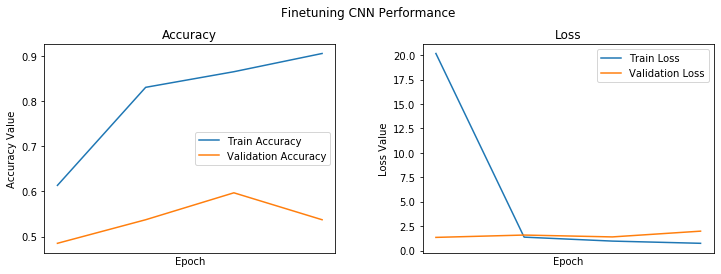

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Finetuning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)


epoch_list = list(range(1, 5))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 5, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 5, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
test_loss, test_acc = model.evaluate(test_imgs_scaled,  test_labels_enc, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)


Test accuracy: 0.5444444417953491

Test Loss: 2.0033842934502495


In [ ]:
predictions = model.predict(test_imgs_scaled)

(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)


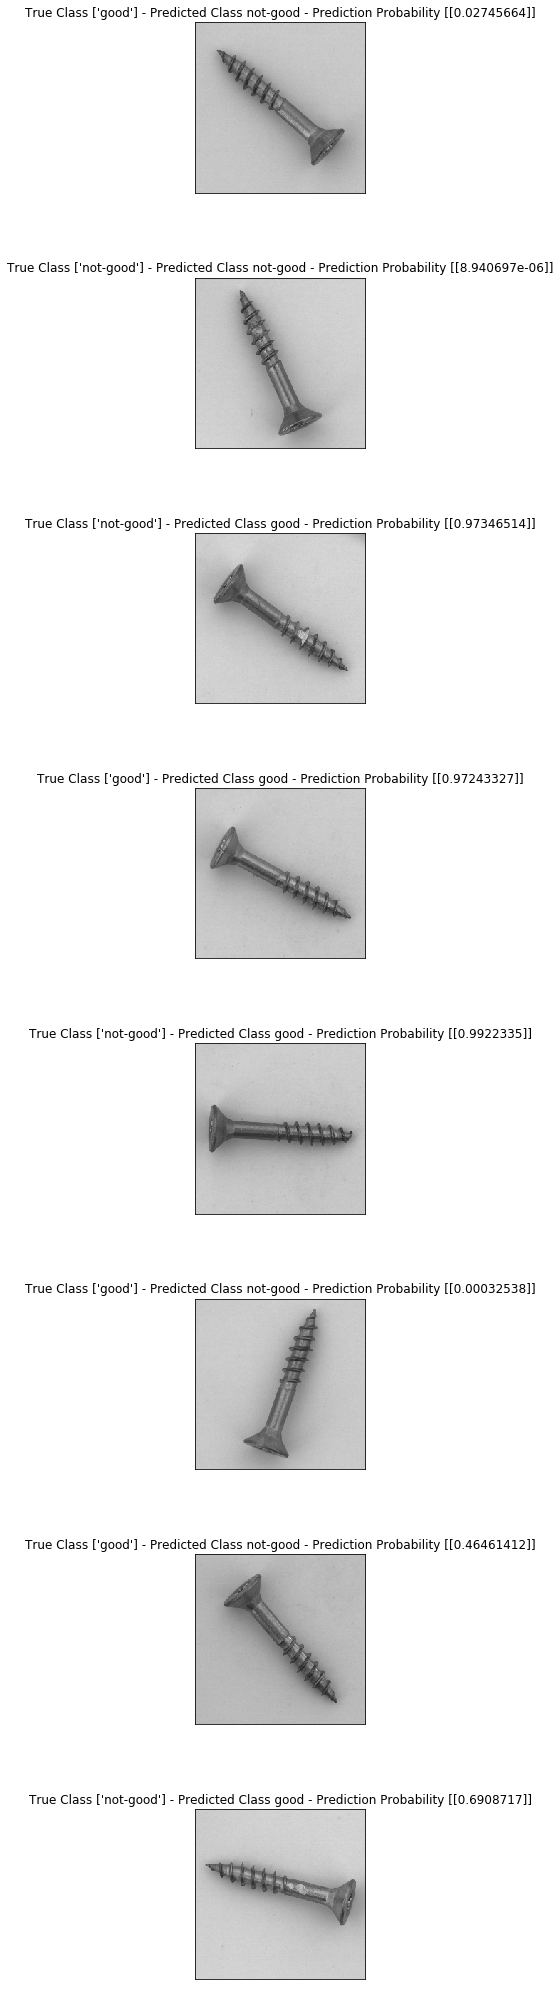

In [ ]:
def predicted_class(prob):
    if prob > 0.5:
        return 'good'
    else:
        return 'not-good'

plt.figure(1 , figsize = (30 , 36))
n = 0 
nb_test_imgs = len(test_imgs_scaled) 
for i in range(8):
    n += 1 
    r = np.random.randint(0 , nb_test_imgs - 1 , 1)
    plt.subplot(8 , 1 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_imgs_scaled[r][0])
    plt.title('True Class {} - Predicted Class {} - Prediction Probability {}'.format(test_labels[r] , predicted_class(predictions[r]),
                               predictions[r]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()